<a href="https://colab.research.google.com/github/edcalderin/DeepLearning_SaturdaysAI/blob/master/6_DeepUnsupervisedLearning/GAN_pr%C3%A1ctica_ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***GAN***
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
!pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
MODEL_NAME = 'VanillaGAN_Saturdays.ai'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(device)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [8]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [9]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [10]:
n_noise = 100

In [11]:
D = Discriminator().to(device)
G = Generator(n_noise).to(device)

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])
                                ]
)

In [13]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
batch_size = 64

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) # Utilizar optimizador Adam con LR 0.0002 y betas=(0.5, 0.999)
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) # Utilizar optimizador Adam con LR 0.0002 y betas=(0.5, 0.999)

In [17]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [18]:
D_labels = torch.ones(batch_size, 1).to(device) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(device) # Discriminator Label to fake

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [20]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(device)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(device)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_z_loss + D_x_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(device)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            plt.imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1


Epoch: 0/50, Step: 0, D Loss: 1.3462103605270386, G Loss: 0.6808770895004272
Epoch: 0/50, Step: 500, D Loss: 1.242538571357727, G Loss: 0.8379873037338257
Epoch: 1/50, Step: 1000, D Loss: 1.3430469036102295, G Loss: 0.7861515879631042
Epoch: 1/50, Step: 1500, D Loss: 1.2877047061920166, G Loss: 0.7866036295890808
Epoch: 2/50, Step: 2000, D Loss: 1.2538108825683594, G Loss: 0.6910497546195984
Epoch: 2/50, Step: 2500, D Loss: 1.1818249225616455, G Loss: 0.9317693114280701
Epoch: 3/50, Step: 3000, D Loss: 1.2701423168182373, G Loss: 0.9679131507873535
Epoch: 3/50, Step: 3500, D Loss: 1.2139031887054443, G Loss: 1.051032304763794
Epoch: 4/50, Step: 4000, D Loss: 1.2509750127792358, G Loss: 0.9545767307281494
Epoch: 4/50, Step: 4500, D Loss: 1.2065258026123047, G Loss: 0.8220800757408142
Epoch: 5/50, Step: 5000, D Loss: 1.3601341247558594, G Loss: 1.090645432472229
Epoch: 5/50, Step: 5500, D Loss: 1.36797034740448, G Loss: 1.03023362159729
Epoch: 6/50, Step: 6000, D Loss: 1.2824113368988037

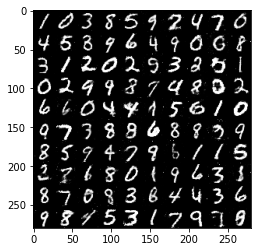

In [21]:
# generation to image
G.eval()
plt.imshow(get_sample_image(G, n_noise), cmap='gray')

In [22]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')